# Sequence to Sequence Lab

Welcome to the sequence to sequence lab! By the end of this lab you will have

- Trained a recurrent neural networks to perform arithmetic
- Written a keras callback to track your model throughout training

Let's get started!

---

# Synthetic Data Parameters

The following code defines a set of hyperparameters describing the synthetic addition dataset.

In [1]:
H = {}

NB_NB = 2

H['NB_DIGIT'] = 10
H['DIGITS'] = list(range(H['NB_DIGIT']))
H['MAXNUM'] = 9
H['MINNUM'], H['LEN_MAXNUM'] = -H['MAXNUM'], len(str(H['MAXNUM']))
H['CHARS'] = [str(d) for d in H['DIGITS']] + [' ', '-', '+']
H['NB_CHAR'] = len(H['CHARS'])
H['MAXLEN_EXPR'] = '+'.join([f'-{H["MAXNUM"]}']*NB_NB)
H['MAXLEN_EXPR'] = len(H['MAXLEN_EXPR'])
H['MAXLEN_ANS'] = len(f'-{str(H["MAXNUM"]*NB_NB)}')
H['NB_TRAIN'] = 10_000

idx_to_char, char_to_idx = {i: c for i, c in enumerate(H['CHARS'])}, {c: i for i, c in enumerate(H['CHARS'])}

H

{'CHARS': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', '-', '+'],
 'DIGITS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'LEN_MAXNUM': 1,
 'MAXLEN_ANS': 3,
 'MAXLEN_EXPR': 5,
 'MAXNUM': 9,
 'MINNUM': -9,
 'NB_CHAR': 13,
 'NB_DIGIT': 10,
 'NB_TRAIN': 10000}

# Generate Equations

The following code will create a list of arithmetic expressions paired with their evaluation.

In [4]:
import numpy as np
import operator
import itertools

sets = [None]*(NB_NB + NB_NB-1)
sets[::2] = [range(H['MINNUM'], H['MAXNUM']+1) for _ in range(NB_NB)]
sets[1::2] = [['+', '-'] for _ in range(NB_NB-1)]

equations = []
for expr in itertools.product(*sets):
    expr = ''.join(str(sub_expr) for sub_expr in expr)
    expr = '%*s' % (H['MAXLEN_EXPR'], expr)
    ans = '%-*d' % (H['MAXLEN_ANS'], eval(expr))
    equations.append([expr, ans])
    
H['NB_TRAIN'] = min(H['NB_TRAIN'], len(equations))
equations[:5]

[['-9+-9', '-18'],
 ['-9+-8', '-17'],
 ['-9+-7', '-16'],
 ['-9+-6', '-15'],
 ['-9+-5', '-14']]

# Vectorize Equations

The following code converts equations into source and target sequences of one-hot character vectors.

In [19]:
list([range(H['MINNUM'], H['MAXNUM']+1) for _ in range(NB_NB)])

[range(-9, 10), range(-9, 10)]

In [17]:
t[1::2]

array([3, 5, 4])

In [5]:
from IPython.display import display
import numpy as np
import pandas as pd

X = np.zeros([H['NB_TRAIN'], H['MAXLEN_EXPR'], H['NB_CHAR']])
y = np.zeros([H['NB_TRAIN'], H['MAXLEN_ANS'], H['NB_DIGIT']+2]) # +2 for ' ' and '-
for i, (expr, ans) in enumerate(equations[:H['NB_TRAIN']]):
    X[np.full(H['MAXLEN_EXPR'], fill_value=i), np.arange(H['MAXLEN_EXPR']), [char_to_idx[c] for c in expr]] = 1
    y[np.full(H['MAXLEN_ANS'], fill_value=i), np.arange(H['MAXLEN_ANS']), [char_to_idx[c] for c in ans]] = 1

idxs = np.arange(len(y))
np.random.shuffle(idxs)
X = X[idxs, :H['NB_TRAIN']]
y = y[idxs, :H['NB_TRAIN']]
equations = [equations[i] for i in idxs][:H['NB_TRAIN']]

print(equations[0])
dfx, dfy = pd.DataFrame(X[0], dtype=np.uint, columns=H['CHARS']), pd.DataFrame(y[0], dtype=np.uint, columns=H['CHARS'][:-1])
dfx.index.name = dfy.index.name = 'Timestep'
display(dfx.style.highlight_max(color='red', axis=1)); display(dfy.style.highlight_max(color='red', axis=1))

['  3-1', '2  ']


In [21]:
X.shape

(722, 5, 13)

In [23]:
X[0]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [22]:
y.shape

(722, 3, 12)

# Define Sequence to Sequence Model

## Tasks

- Define a keras sequence to sequence model that maps arithmetic expressions to number values

## Requirements

- Use the data parameters in `H` to define the dimensions of your architecture
- Fit your model to training data with `NB_NB=2` and `MAXNUM=9`
- Report accuracy on a `validation_split=.1`

## Hints

- Refer to the [`keras.examples.addition_rnn.py`](https://github.com/fchollet/keras/blob/master/examples/addition_rnn.py) for an example architecture which performs addition
- Start off simple (e.g. one LSTM layer for the encoder and one LSTM layer for the decoder)
- Use the following callback to visualize model performance during training
- Start simple with the smallest model you can think of to diagnose underfitting/overfitting and go from there

In [283]:
from keras.layers import Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Sequential
import keras as keras
import IPython
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [284]:
X.shape

(722, 5, 13)

In [285]:
y.shape

(722, 3, 12)

In [286]:
class TrainingVisualizer(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        IPython.display.clear_output(wait=True)
        pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('loss')}).plot()
        axes = pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('acc')}).plot()
        axes.set_ylim([0, 1])
        plt.show()

In [ ]:
BATCH_SIZE=64
num_layers=1

In [298]:
model = Sequential()

In [299]:
model.add(LSTM(256,activation='relu',return_sequences=False, batch_input_shape = [None,5,13])) # encoder

In [300]:
model.add(RepeatVector(3))
for _ in range(num_layers):
    model.add(LSTM(128,activation='relu',return_sequences=True)) # decoder sequences


In [301]:
model.add(TimeDistributed(Dense(12, activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 256)               276480    
_________________________________________________________________
repeat_vector_34 (RepeatVect (None, 3, 256)            0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 3, 128)            197120    
_________________________________________________________________
lstm_56 (LSTM)               (None, 3, 128)            131584    
_________________________________________________________________
lstm_57 (LSTM)               (None, 3, 128)            131584    
_________________________________________________________________
time_distributed_36 (TimeDis (None, 3, 12)             1548      
Total params: 738,316.0
Trainable params: 738,316.0
Non-trainable params: 0.0
________________________________________________________________

In [434]:
X.shape

(722, 5, 13)

In [483]:
 X_train, X_test = X[:700,:,:],X[700:,:,:],
y_train, y_test = y[:700,:,:],y[700:,:,:]

In [485]:
X_test.shape

(22, 5, 13)

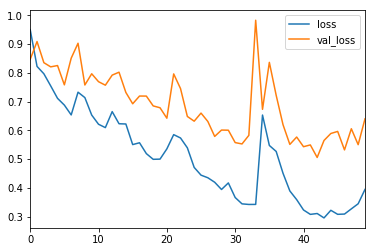

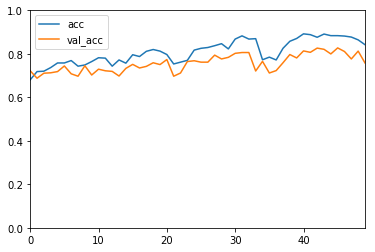

361/361 [==============================] - 1s - loss: 0.3945 - acc: 0.8421 - val_loss: 0.6401 - val_acc: 0.7581


In [305]:
model.fit(X_test, y_test,
              batch_size=BATCH_SIZE,
              epochs=50,
              validation_data=[X_train,y_train], callbacks=[TrainingVisualizer()])

In [ ]:
model.evaluate()

### Test a bigger model

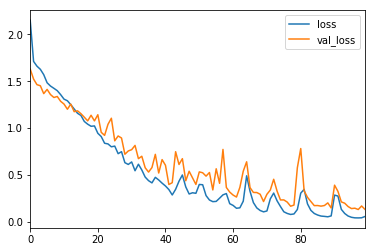

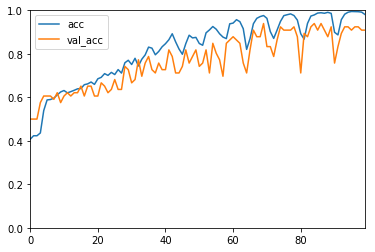

700/700 [==============================] - 3s - loss: 0.0589 - acc: 0.9810 - val_loss: 0.1344 - val_acc: 0.9091


In [487]:
BATCH_SIZE=32
num_layers=2
model = Sequential()
model.add(LSTM(256,activation='relu',return_sequences=False, batch_input_shape = [None,5,13]
              )) # encoder
#model.add(LSTM(128,activation='relu',return_sequences=False, batch_input_shape = [None,5,13]
 #             )) # encoder
model.add(RepeatVector(3))
for _ in range(num_layers):
    model.add(LSTM(256,activation='relu',return_sequences=True)) # decoder sequences
#model.add(TimeDistributed(Dense(512,activation='relu')))
model.add(TimeDistributed(Dense(12, activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
model.fit(X_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=100,
              validation_data=[X_test,y_test], callbacks=[TrainingVisualizer()])

In [488]:
model.evaluate(X_test,y_test)

22/22 [==============================] - 0s


[0.13435450196266174, 0.90909093618392944]

# Question

Is your model underfitting or overfitting the data or can't you quite tell? Justify your answer with appropriate data and visualizations.

In [ ]:
# My model is underfitting the data because the training error is nowhere near 0%

# Bonus Tasks

---

# Error Analysis

It is time to get some insight into your model.

## Task

- Create a keras callback which has the model make predictions on a sample of held-out data points and display its guesses
- Refit the model on the training data and use this callback during training

## Requirements

- Have this callback run at the beginning of every epoch so you can see how the model is performing over time

## Question

- What types of data points do you think the model is having the most difficult time with?

In [489]:
predictions = model.predict(X_test)

In [490]:
# Input
[H['CHARS'][np.argmax(i)] for i in X_test[0]]

[' ', '-', '4', '+', '9']

In [491]:
# Prediction
[H['CHARS'][np.argmax(i)] for i in predictions[0]]

['4', ' ', ' ']

In [492]:
#Actual
[H['CHARS'][np.argmax(i)] for i in y_test[0]]

['5', ' ', ' ']

In [493]:
list([H['CHARS'][np.argmax(i)] for i in y_test[0]])==list([H['CHARS'][np.argmax(i)] for i in predictions[0]])

False

In [494]:
list([H['CHARS'][np.argmax(i)] for i in y_test[1]])==list([H['CHARS'][np.argmax(i)] for i in predictions[0]])

False

In [495]:
len(predictions)

22

In [496]:
len(y_test)

22

In [497]:
len(X_train)

700

In [499]:
count_correct = 0
count_incorrect = 0

for prediction_num in range(len(predictions)):
    print(prediction_num)
    result = list([H['CHARS'][np.argmax(i)] for i in y_test[prediction_num]])\
        ==list([H['CHARS'][np.argmax(i)] for i in predictions[prediction_num]])
    if result != True:
        print('Our model could not predict {}'.format([H['CHARS'][np.argmax(i)] for i in X_test[prediction_num]]))

        print('The answer our model found was {}'.format([H['CHARS'][np.argmax(i)] for i in predictions[prediction_num]]))
        print('The correct answer is {}'.format([H['CHARS'][np.argmax(i)] for i in y_test[prediction_num]]))
        count_incorrect+=1
    else:
        count_correct+=1
print()
print("The accuarcy was {}".format(count_correct/(count_correct+count_incorrect)))

0
Our model could not predict [' ', '-', '4', '+', '9']
The answer our model found was ['4', ' ', ' ']
The correct answer is ['5', ' ', ' ']
1
2
3
Our model could not predict ['-', '9', '-', '-', '8']
The answer our model found was ['0', ' ', ' ']
The correct answer is ['-', '1', ' ']
4
5
Our model could not predict ['-', '3', '-', '-', '4']
The answer our model found was ['0', ' ', ' ']
The correct answer is ['1', ' ', ' ']
6
7
8
Our model could not predict ['-', '4', '-', '-', '5']
The answer our model found was ['0', ' ', ' ']
The correct answer is ['1', ' ', ' ']
9
10
11
Our model could not predict ['-', '6', '-', '-', '8']
The answer our model found was ['1', ' ', ' ']
The correct answer is ['2', ' ', ' ']
12
13
14
15
16
17
18
19
20
21

The accuarcy was 0.7727272727272727


## Question

- What type of expressions is your model struggling the most with predicting correctly?

## Requirements

- Justify your answer with appropriate plots and reasoning.

In [ ]:
# our model has a tough time with double negatives

# Task

- Experiment with different numbers of intermediate plus and minus signs. Can you find the relationship between these numbers and the size of an LSTM (e.g. number of layers)?